# Equações Governantes

O escoamento monofásico incompressível através de um meio poroso heterogêneo é descrito por:

## Lei de Darcy
$$
\mathbf{u} = -\mathbf{K}(x,y)\,\nabla p
$$

## Equação da Continuidade
$$
\nabla \cdot \mathbf{u} = 0
$$

Onde:
$$
\mathbf{u} = \text{vetor velocidade}, \qquad
p = \text{pressão}, \qquad
\mathbf{K} = \text{tensor de permeabilidade}.
$$

---






# 2. Problema de Upscaling

## Objetivo
Encontrar permeabilidades homogêneas que reproduzam o mesmo fluxo total da solução na escala fina.

## Equação na Escala Grossa
$$
\nabla \cdot\left(-\mathbf{K}^\ast(X,Y)\,\nabla p\right) = 0
$$
onde $\mathbf{K}^\ast$ é o tensor de permeabilidade efetiva.

---



# 3. Formulação do Problema Forte

## Combinação das Equações
$$
\nabla\cdot\left(-\mathbf{K}(x,y)\,\nabla p\right) = 0
$$

## Condições de Contorno

**Caso 1 — Gradiente na direção $x$:**
$$
p(0,y)=1, \qquad p(L_x,y)=0,
$$
$$
\mathbf{u}(x,0)\cdot\mathbf{n}=0, \qquad
\mathbf{u}(x,L_y)\cdot\mathbf{n}=0.
$$

**Caso 2 — Gradiente na direção $y$:**
$$
p(x,0)=1, \qquad p(x,L_y)=0,
$$
$$
\mathbf{u}(0,y)\cdot\mathbf{n}=0, \qquad
\mathbf{u}(L_x,y)\cdot\mathbf{n}=0.
$$

---



# 3. Formulação do Problema Forte

## Combinação das Equações
$$
\nabla\cdot\left(-\mathbf{K}(x,y)\,\nabla p\right) = 0
$$

## Condições de Contorno

**Caso 1 — Gradiente na direção $x$:**
$$
p(0,y)=1, \qquad p(L_x,y)=0,
$$
$$
\mathbf{u}(x,0)\cdot\mathbf{n}=0, \qquad
\mathbf{u}(x,L_y)\cdot\mathbf{n}=0.
$$

**Caso 2 — Gradiente na direção $y$:**
$$
p(x,0)=1, \qquad p(x,L_y)=0,
$$
$$
\mathbf{u}(0,y)\cdot\mathbf{n}=0, \qquad
\mathbf{u}(L_x,y)\cdot\mathbf{n}=0.
$$

---

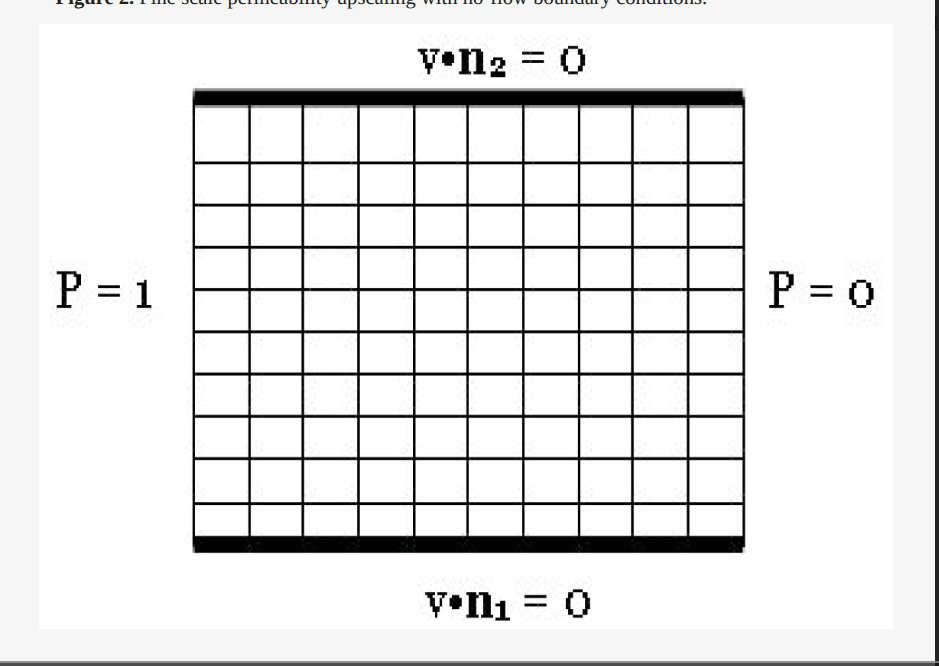



# 4. Forma Fraca

## Passos da Derivação

**Equação diferencial:**
$$
\nabla\cdot(-\mathbf{K}\,\nabla p)=0
$$

**Multiplicação por função teste $v$:**
$$
\int_\Omega \left[\nabla\cdot(-\mathbf{K}\nabla p)\right]\,v\,dx = 0
$$

**Integração por partes:**
$$
\int_\Omega \mathbf{K}\,\nabla p\cdot\nabla v\,dx
-
\int_{\Gamma} v\,(\mathbf{K}\,\nabla p\cdot\mathbf{n})\,ds = 0
$$

**Neumann (fluxo zero):**
$$
\mathbf{K}\,\nabla p\cdot\mathbf{n}=0 \quad \text{em }\Gamma_N
$$

**Forma fraca final:**
$$
\int_\Omega \mathbf{K} \nabla p \cdot \nabla v \, dx = 0 \quad \forall v \in V
$$

**Espaços:**
- Pressão: $p \in H^1(\Omega)$ → CG1 (contínuo)
- Permeabilidade: $\mathbf{K} \in L^2(\Omega)$ → DG0 (descontínuo/elemento)

---
---




## Fluxo Efetivo na Borda de Saída

$$Q = \int_{\partial\Omega_{saida}} (-\mathbf{K} \nabla p) \cdot \mathbf{n} \, dS$$

**Lei de Darcy 1D (para domínio unitário):**
$$Q = -K \frac{\Delta p}{\Delta x} A = -K \cdot 1 \cdot 1 \cdot 1 = -K$$

**Portanto:**
$$K_{eff} = |Q| \quad \text{(módulo garante K ≥ 0)}$$

---

## Resumo 
| Etapa | Entrada | Processo | Saída |
|-------|---------|----------|-------|
| **Geração** | Parâmetros aleatórios | Funções trig + DG0 | $K(x,y)$ |
| **Resolução** | $K(x,y)$ + BCs | Firedrake FEM | $p(x,y)$ |
| **Fluxo** | $p(x,y)$ + $K(x,y)$ | Integral de borda | $Q = \int -K\nabla p \cdot n$ |
| **Output** | $Q$ | $\|Q\|$ | $K_{eff}$ |


In [40]:
import firedrake as fd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.patches import Rectangle
import os
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# CONFIGURAÇÃO E DOMÍNIO



In [41]:
NUM_SIMULACOES = 10        # Número de amostras
# Aumentar para mais de 1000 para treinamento real
RESOLUCAO_MALHA = 20       # Discretização do REV
# Aumentar para 50 ou 100 para treinamento real

PASTA_DADOS = "/home/dairsonalbert/projeto_final_FEM_Mecanica/projeto-fem-mec-continuo/dataset_deeponet"

# Criar pasta se não existir
os.makedirs(PASTA_DADOS, exist_ok=True)

print(f" Dataset será salvo em:\n{PASTA_DADOS}")


 Dataset será salvo em:
/home/dairsonalbert/projeto_final_FEM_Mecanica/projeto-fem-mec-continuo/dataset_deeponet


# CRIAR DOMÍNIO E ESPAÇOS FUNCIONAIS


Domínio discretizado:
  • Número de elementos finitos ($|\mathcal{T}_h|$): 800
  • Graus de Liberdade (DoFs) do espaço $L^2$ (DG0): 800


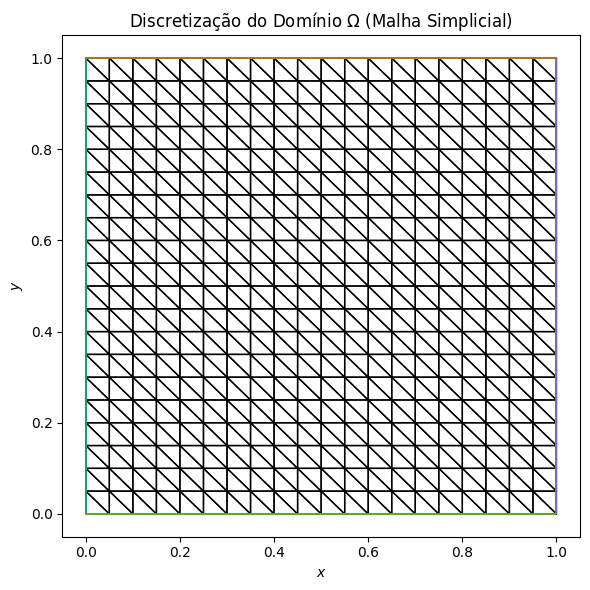

 Medida de Lebesgue calculada ($\int_\Omega d\Omega$): 1.0000


In [42]:
import firedrake as fd  # Assumindo a biblioteca Firedrake baseada no contexto
import matplotlib.pyplot as plt

# ==============================================================================
# 1. DISCRETIZAÇÃO DO DOMÍNIO ESPACIAL
# ==============================================================================
# Define o domínio computacional $\Omega = [0, 1] \times [0, 1] \subset \mathbb{R}^2$.
# A malha é uma tesselação $\mathcal{T}_h$ composta por elementos simpliciais (triângulos).
# quadrilateral=False impõe a topologia simplex, essencial para bases baricêntricas.
malha = fd.UnitSquareMesh(RESOLUCAO_MALHA, RESOLUCAO_MALHA, quadrilateral=False)

# ==============================================================================
# 2. DEFINIÇÃO DE ESPAÇOS FUNCIONAIS (FUNCTION SPACES)
# ==============================================================================
# Espaço de aproximação para a variável de estado escalar (Pressão $p$).
# Utiliza a família de Lagrange ("CG" - Continuous Galerkin) de ordem $k=1$.
# Matematicamente: $V_p = \{v \in H^1(\Omega) : v|_K \in P_1(K), \forall K \in \mathcal{T}_h\}$.
# Garante continuidade $C^0$ através das fronteiras dos elementos.
V_pressao = fd.FunctionSpace(malha, "CG", 1)

# Espaço de aproximação para parâmetros materiais (Permeabilidade $\kappa$).
# Utiliza a família Descontínua ("DG" - Discontinuous Galerkin) de ordem $k=0$.
# Matematicamente: $V_\kappa = \{v \in L^2(\Omega) : v|_K \in P_0(K), \forall K \in \mathcal{T}_h\}$.
# Permite descontinuidades abruptas entre elementos (ideal para meios heterogêneos).
V_permeabilidade = fd.FunctionSpace(malha, "DG", 0)

# ==============================================================================
# 3. DEFINIÇÕES VARIACIONAIS E GEOMÉTRICAS
# ==============================================================================
# Representação simbólica do vetor de coordenadas $\vec{x} = (x, y)$.
x, y = fd.SpatialCoordinate(malha)

# Vetor normal unitário exterior $\hat{n}$ definido na fronteira $\partial\Omega$ e
# nas interfaces dos elementos $\partial K$.
# Fundamental para aplicação do Teorema da Divergência (integração por partes)
# na formulação fraca e cálculo de fluxos numéricos.
n = fd.FacetNormal(malha)

# ==============================================================================
# 4. ANÁLISE DE GRAUS DE LIBERDADE (DoFs)
# ==============================================================================
# O número de nós (DoFs) no espaço DG0 corresponde ao cardinal de elementos na malha,
# pois existe exatamente 1 incógnita constante por elemento.
num_nodos = V_permeabilidade.dim()
print(f"\nDomínio discretizado:")
# Para uma malha estruturada NxN dividida em triângulos, temos $2N^2$ elementos.
print(f"  • Número de elementos finitos ($|\mathcal{{T}}_h|$): {RESOLUCAO_MALHA**2 * 2}")
print(f"  • Graus de Liberdade (DoFs) do espaço $L^2$ (DG0): {num_nodos}")

# ==============================================================================
# 5. INSPEÇÃO TOPOLÓGICA E VERIFICAÇÃO INTEGRAL
# ==============================================================================
# Visualização da qualidade da malha e conectividade nodal.
fig, ax = plt.subplots(figsize=(6, 6))
fd.triplot(malha, axes=ax)
ax.set_title(r"Discretização do Domínio $\Omega$ (Malha Simplicial)")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
plt.tight_layout()
plt.show()

# Verificação de consistência da medida de Lebesgue via quadratura numérica.
# Calcula $\int_\Omega 1 \, d\Omega$. Deve convergir para a área analítica (1.0).
# O termo fd.dx indica integração sobre o interior dos elementos canônicos.
area_total = fd.assemble(fd.Constant(1.0) * fd.dx(malha))
print(f" Medida de Lebesgue calculada ($\int_\Omega d\Omega$): {float(area_total):.4f}")

LISTAS PARA ARMAZENAR DADOS


In [43]:
# ============================================================
# Formulação do Problema de Darcy (visão operador → dado)
# ============================================================
# Considera-se o problema elíptico de Darcy em um domínio Ω ⊂ ℝ²:
#
#   - ∇ · ( K(x,y) ∇p(x,y) ) = f        em Ω
#
# onde:
#   • K(x,y) é o campo de permeabilidade heterogênea do meio poroso;
#   • p(x,y) é o campo de pressão (incógnita resolvida numericamente);
#   • f representa termos fonte/sumidouro (aqui omitidos ou implícitos).
#
# A quantidade de interesse (Quantity of Interest – QoI) é o fluxo
# macroscópico resultante através da fronteira do domínio, dado por:
#
#   Q = ∫_{∂Ω} ( -K ∇p )import os · n \, dS
#
# Esse fluxo integrado é utilizado para definir a permeabilidade efetiva
# K_eff do meio, conectando a microestrutura (K local) à resposta global.

# ============================================================
# Estrutura dos dados armazenados
# ============================================================
# As listas abaixo organizam o conjunto de dados necessário para:
#   • análise numérica,
#   • pós-processamento físico,
#   • e eventual treinamento de modelos de aprendizado de operador
#     (ex.: DeepONet ou redes substitutas).

# ------------------------------------------------------------
# lista_K:
#   Armazena realizações do campo de permeabilidade K(x,y),
#   definidas no espaço DG0 (valor constante por elemento).
#   Representa a ENTRADA do problema físico e do operador.
lista_K = []

# ------------------------------------------------------------
# lista_K_eff:
#   Armazena os valores de permeabilidade efetiva (K_xx^eff, K_yy^eff),
#   obtidos a partir do fluxo integrado na fronteira do domínio.
#   Representa a SAÍDA macroscópica do problema de Darcy.
lista_K_eff = []

# ------------------------------------------------------------
# lista_pressao_x:
#   Campos de pressão p(x,y) obtidos impondo gradiente médio
#   na direção x.
#   Esses campos não são usados como saída do operador,
#   mas são armazenados para análise física e visualização.
lista_pressao_x = []

# ------------------------------------------------------------
# lista_pressao_y:
#   Campos de pressão p(x,y) obtidos impondo gradiente médio
#   na direção y, análogo ao caso x.
#   Permite estudar anisotropia induzida pela heterogeneidade.
lista_pressao_y = []

# ------------------------------------------------------------
# Observação importante sobre p_x e p_y:
#   As variáveis p_x e p_y correspondem às soluções temporárias
#   do problema variacional resolvido pelo Firedrake.
#   Elas NÃO são armazenadas diretamente; apenas:
#     • são usadas para calcular o fluxo na fronteira,
#     • e então descartadas após a extração da QoI.
#
# Isso reflete uma abordagem orientada a operadores:
#   p(x,y) é um estado intermediário,
#   enquanto Q (ou K_eff) é o objeto de interesse final.

# ------------------------------------------------------------
# lista_sensor_locs:
#   Armazena as coordenadas dos centros dos elementos da malha,
#   interpretadas como "sensores" espaciais.
#   Essas localizações são particularmente úteis para:
#     • amostragem do campo K,
#     • definição de entradas discretizadas,
#     • treinamento de modelos baseados em sensores (DeepONet).
lista_sensor_locs = []


In [44]:
print(f"\n{'='*70}")
print(f"INICIANDO GERAÇÃO DE DADOS (ETAPA 2)")
print(f"{'='*70}")

# Marca temporal para avaliação do custo computacional total da etapa
tempo_inicio = time.time()

# =============================================================================
# LOOP PRINCIPAL: GERAÇÃO DO CONJUNTO DE DADOS NUMÉRICOS
# =============================================================================
# Cada iteração do loop corresponde a uma realização independente
# de um meio poroso heterogêneo e anisotrópico, seguida da resolução
# do problema elíptico de Darcy associado.
#
# O objetivo global é construir um conjunto de dados do tipo:
#
#     { K(x, y) }  →  { K_eff }
#
# caracterizando um processo numérico de homogeneização,
# no qual propriedades efetivas macroscópicas são inferidas
# a partir de microestruturas espacialmente variáveis.
#
for sim_id in tqdm(range(NUM_SIMULACOES), desc="Simulações FEM"):
    
    # -------------------------------------------------------------------------
    # CONTROLE DE REPRODUTIBILIDADE
    # -------------------------------------------------------------------------
    # A utilização de uma seed fixa por simulação garante que
    # cada realização possa ser reproduzida exatamente,
    # um requisito fundamental em experimentos computacionais científicos.
    np.random.seed(sim_id)
    
    # =========================================================================
    # 1. GERAÇÃO DA MICROESTRUTURA HETEROGÊNEA ANISOTRÓPICA
    # =========================================================================
    # O campo de permeabilidade é construído sinteticamente por meio
    # de combinações de funções trigonométricas suaves.
    #
    # Essa escolha permite:
    #   • controle estatístico da heterogeneidade
    #   • regularidade espacial
    #   • fácil reprodução e análise
    #
    # A anisotropia é introduzida explicitamente ao permitir que
    # os parâmetros associados às direções x e y sejam distintos.
    
    # Frequências espaciais independentes nas direções x e y
    freq_x = np.random.uniform(2.0, 6.0)
    freq_y = np.random.uniform(2.0, 6.0)
    
    # Amplitudes associadas à direção x
    amp1_x = np.random.uniform(0.3, 0.8)
    amp2_x = np.random.uniform(0.3, 0.8)

    # Amplitudes associadas à direção y (diferentes → anisotropia)
    amp1_y = np.random.uniform(0.3, 0.8)
    amp2_y = np.random.uniform(0.3, 0.8)
    
    # Fases aleatórias para evitar alinhamentos artificiais
    fase_x = np.random.uniform(0, 2*np.pi)
    fase_y = np.random.uniform(0, 2*np.pi)
    
    # =========================================================================
    # DEFINIÇÃO DO TENSOR DE PERMEABILIDADE ANISOTRÓPICO
    # =========================================================================
    # Considera-se um tensor de permeabilidade diagonal da forma:
    #
    #     K(x,y) = [ K_xx(x,y)   0       ]
    #              [   0     K_yy(x,y) ]
    #
    # Não são considerados termos fora da diagonal (K_xy = K_yx = 0),
    # mas as componentes principais K_xx e K_yy diferem espacialmente,
    # caracterizando anisotropia direcional.
    
    # -------------------------------------------------------------------------
    # Componente K_xx(x,y)
    # -------------------------------------------------------------------------
    K_xx_expr = 0.5 + 0.5 * (
        amp1_x * fd.sin(freq_x * np.pi * x + fase_x) *
        fd.cos(freq_y * np.pi * y + fase_y) +
        amp2_x * fd.cos(freq_x * np.pi * x) *
        fd.sin(freq_y * np.pi * y)
    )
    
    # Impõe positividade estrita da permeabilidade,
    # condição necessária para garantir a elipticidade do operador
    # e a boa colocação do problema de Darcy.
    K_xx_expr = 0.1 + 0.9 * fd.conditional(K_xx_expr > 0, K_xx_expr, -K_xx_expr)
    
    # -------------------------------------------------------------------------
    # Componente K_yy(x,y) — distinta de K_xx
    # -------------------------------------------------------------------------
    K_yy_expr = 0.5 + 0.5 * (
        amp1_y * fd.sin(freq_x * np.pi * x + fase_x) *
        fd.cos(freq_y * np.pi * y + fase_y) +
        amp2_y * fd.cos(freq_x * np.pi * x) *
        fd.sin(freq_y * np.pi * y)
    )

    K_yy_expr = 0.1 + 0.9 * fd.conditional(K_yy_expr > 0, K_yy_expr, -K_yy_expr)
    
    # -------------------------------------------------------------------------
    # PROJEÇÃO PARA O ESPAÇO DG0
    # -------------------------------------------------------------------------
    # O campo de permeabilidade é representado como constante por elemento,
    # o que é consistente com:
    #   • formulações clássicas de meios porosos
    #   • esquemas de volumes/elementos finitos
    #   • estratégias de upscaling numérico
    
    K_xx = fd.Function(V_permeabilidade).interpolate(K_xx_expr)
    K_yy = fd.Function(V_permeabilidade).interpolate(K_yy_expr)
    
    # Verificação de sanidade numérica (proteção contra falhas)
    if np.any(np.isnan(K_xx.dat.data)) or np.any(np.isnan(K_yy.dat.data)):
        continue 
    
    # =========================================================================
    # 2. FORMULAÇÃO VARIACIONAL DO PROBLEMA DE DARCY ANISOTRÓPICO
    # =========================================================================
    # Formulação fraca:
    #
    # Encontrar p ∈ V tal que:
    #
    # ∫_Ω [ K_xx ∂p/∂x ∂v/∂x + K_yy ∂p/∂y ∂v/∂y ] dΩ = 0
    #
    # para todo v ∈ V₀,
    #
    # onde V é o espaço funcional da pressão com condições de Dirichlet.
    
    p_trial = fd.TrialFunction(V_pressao)
    v_test = fd.TestFunction(V_pressao)
    
    # Forma bilinear elíptica associada ao operador de Darcy anisotrópico
    a = (
        K_xx * p_trial.dx(0) * v_test.dx(0) +
        K_yy * p_trial.dx(1) * v_test.dx(1)
    ) * fd.dx
    
    # Termo fonte nulo (escoamento puramente induzido por gradiente)
    L = fd.Constant(0.0) * v_test * fd.dx
    
    # =========================================================================
    # 3. PROBLEMA COM GRADIENTE IMPOSTO NA DIREÇÃO X
    # =========================================================================
    # Condições de contorno:
    #   p = 1 em x = 0
    #   p = 0 em x = 1
    #
    # Essa configuração impõe um gradiente médio unitário na direção x,
    # induzindo um escoamento predominantemente horizontal.
    
    p_x = fd.Function(V_pressao)
    bcs_x = [
        fd.DirichletBC(V_pressao, fd.Constant(1.0), 1),
        fd.DirichletBC(V_pressao, fd.Constant(0.0), 2)
    ]
    
    fd.solve(
        a == L, p_x, bcs=bcs_x,
        solver_parameters={'ksp_type': 'cg', 'pc_type': 'hypre'}
    )
    
    # =========================================================================
    # PÓS-PROCESSAMENTO: CÁLCULO DO FLUXO E HOMOGENEIZAÇÃO
    # =========================================================================
    
    # Fluxo total atravessando a fronteira de saída (x = 1)
    # Q = ∫_{Γ_out} ( -K ∇p · n ) ds
    fluxo_x = fd.assemble(fd.dot(-K_xx * fd.grad(p_x), n) * fd.ds(2))
    
    # Permeabilidade efetiva na direção x.
    # Para um domínio unitário e Δp = 1, o valor numérico de K_eff
    # coincide com a magnitude do fluxo médio.
    # K_xx_eff = (Fluxo * Comprimento) / (Area * Delta_Pressao)
    K_xx_eff = abs(float(fluxo_x))
    
    # =========================================================================
    # 4. PROBLEMA COM GRADIENTE IMPOSTO NA DIREÇÃO Y
    # =========================================================================
    # Condições de contorno:
    #   p = 1 em y = 0
    #   p = 0 em y = 1
    
    p_y = fd.Function(V_pressao)
    bcs_y = [
        fd.DirichletBC(V_pressao, fd.Constant(1.0), 3),
        fd.DirichletBC(V_pressao, fd.Constant(0.0), 4)
    ]
    
    fd.solve(
        a == L, p_y, bcs=bcs_y,
        solver_parameters={'ksp_type': 'cg', 'pc_type': 'hypre'}
    )
    
    # Fluxo total atravessando a fronteira superior (y = 1)
    fluxo_y = fd.assemble(fd.dot(-K_yy * fd.grad(p_y), n) * fd.ds(4))
    K_yy_eff = abs(float(fluxo_y))
    
    # =========================================================================
    # 5. EXTRAÇÃO E ARMAZENAMENTO DOS DADOS
    # =========================================================================
    # Os dados são armazenados como arrays NumPy,
    # tornando o conjunto final independente do Firedrake
    # e adequado para uso em modelos de aprendizado de máquina.
    
    K_xx_data = K_xx.dat.data_ro.copy()
    K_yy_data = K_yy.dat.data_ro.copy()
    
    p_x_data = p_x.dat.data_ro.copy()
    p_y_data = p_y.dat.data_ro.copy()
    
    # Entrada: microestrutura anisotrópica
    lista_K.append([K_xx_data, K_yy_data])
    
    # Saída: permeabilidades efetivas direcionais
    lista_K_eff.append([K_xx_eff, K_yy_eff])
    
    # Campos de pressão (úteis para análise física e validação)
    lista_pressao_x.append(p_x_data)
    lista_pressao_y.append(p_y_data)

# =============================================================================
# RELATÓRIO FINAL DA GERAÇÃO DE DADOS
# =============================================================================
print(f"\nTempo total geração de dados: {time.time() - tempo_inicio:.1f}s")
print(f"Amostras geradas com sucesso: {len(lista_K)}/{NUM_SIMULACOES}")
print(f"Permeabilidade anisotrópica confirmada (K_xx ≠ K_yy)")
print(f"Campos de pressão armazenados:")
print(f"  • Direção X: {len(lista_pressao_x)} amostras")
print(f"  • Direção Y: {len(lista_pressao_y)} amostras")



INICIANDO GERAÇÃO DE DADOS (ETAPA 2)


Simulações FEM: 100%|██████████| 10/10 [00:00<00:00, 38.46it/s]


Tempo total geração de dados: 0.3s
Amostras geradas com sucesso: 10/10
Permeabilidade anisotrópica confirmada (K_xx ≠ K_yy)
Campos de pressão armazenados:
  • Direção X: 10 amostras
  • Direção Y: 10 amostras


In [45]:
# =============================================================================
# CONVERSÃO E ARMAZENAMENTO DO DATASET NUMÉRICO
# =============================================================================
# Nesta etapa, os dados gerados durante as simulações FEM são organizados
# em arrays NumPy e persistidos em disco, permitindo:
#   • reutilização independente do Firedrake
#   • treinamento de modelos de aprendizado de máquina
#   • reprodutibilidade completa do experimento
#
# Estrutura do dataset:
#   X_train → campos de permeabilidade anisotrópica [K_xx(x,y), K_yy(x,y)]
#   y_train → permeabilidades efetivas direcionais [K_xx_eff, K_yy_eff]
#   coords  → coordenadas espaciais da malha computacional
#

# Conversão das listas acumuladas durante o loop para arrays NumPy
X_train = np.array(lista_K)          # Shape: (n_amostras, 2, n_elementos)
y_train = np.array(lista_K_eff)      # Shape: (n_amostras, 2) → [K_xx_eff, K_yy_eff]

# Coordenadas dos nós da malha (informação geométrica fixa)
coords_nodos = malha.coordinates.dat.data_ro.copy()

print(f"\n{'='*70}")
print(f"SALVANDO DATASET GERADO")
print(f"{'='*70}")

# Verificação das dimensões para garantir consistência estrutural
print(f"\nFormas dos dados:")
print(f"  X_train (microestruturas): {X_train.shape}")
print(f"  y_train (permeabilidades efetivas): {y_train.shape}")
print(f"  coords_nodos (geometria da malha): {coords_nodos.shape}")

# -------------------------------------------------------------------------
# Persistência dos dados em formato .npy
# -------------------------------------------------------------------------
# O formato NumPy (.npy) é escolhido por:
#   • eficiência em leitura/escrita
#   • preservação exata dos tipos e dimensões
#   • ampla compatibilidade com pipelines de ML
#
np.save(os.path.join(PASTA_DADOS, "X_train.npy"), X_train)
np.save(os.path.join(PASTA_DADOS, "y_train.npy"), y_train)
np.save(os.path.join(PASTA_DADOS, "coords.npy"), coords_nodos)

print(f"\nArquivos salvos em '{PASTA_DADOS}/':")
print(f" X_train.npy  → campos de permeabilidade anisotrópica")
print(f" y_train.npy  → permeabilidades efetivas direcionais")
print(f" coords.npy   → coordenadas espaciais da malha")

# =============================================================================
# ANÁLISE ESTATÍSTICA DOS DADOS GERADOS
# =============================================================================
# As estatísticas a seguir permitem:
#   • verificar a variabilidade do dataset
#   • identificar possíveis vieses numéricos
#   • caracterizar o grau médio de anisotropia
#   • validar a diversidade física das amostras
#

print(f"\n{'='*70}")
print(f"ESTATÍSTICAS DOS DADOS GERADOS")
print(f"{'='*70}")

# -------------------------------------------------------------------------
# Estatísticas da permeabilidade efetiva na direção x
# -------------------------------------------------------------------------
print(f"\nPermeabilidade Efetiva – Direção X (K_xx_eff):")
print(f"  Média: {np.mean(y_train[:, 0]):.4f}")
print(f"  Desvio padrão: {np.std(y_train[:, 0]):.4f}")
print(f"  Mínimo: {np.min(y_train[:, 0]):.4f}")
print(f"  Máximo: {np.max(y_train[:, 0]):.4f}")

# -------------------------------------------------------------------------
# Estatísticas da permeabilidade efetiva na direção y
# -------------------------------------------------------------------------
print(f"\nPermeabilidade Efetiva – Direção Y (K_yy_eff):")
print(f"  Média: {np.mean(y_train[:, 1]):.4f}")
print(f"  Desvio padrão: {np.std(y_train[:, 1]):.4f}")
print(f"  Mínimo: {np.min(y_train[:, 1]):.4f}")
print(f"  Máximo: {np.max(y_train[:, 1]):.4f}")

# -------------------------------------------------------------------------
# Medida escalar de anisotropia macroscópica
# -------------------------------------------------------------------------
# A razão K_xx_eff / K_yy_eff fornece uma medida direta
# do grau de anisotropia hidráulica efetiva do meio.
anisotropia = y_train[:, 0] / y_train[:, 1]

print(f"\nAnisotropia Macroscópica (K_xx_eff / K_yy_eff):")
print(f"  Média: {np.mean(anisotropia):.4f}")
print(f"  Mínimo: {np.min(anisotropia):.4f}")
print(f"  Máximo: {np.max(anisotropia):.4f}")

print(f"\n{'='*70}")



SALVANDO DATASET GERADO

Formas dos dados:
  X_train (microestruturas): (10, 2, 800)
  y_train (permeabilidades efetivas): (10, 2)
  coords_nodos (geometria da malha): (441, 2)

Arquivos salvos em '/home/dairsonalbert/projeto_final_FEM_Mecanica/projeto-fem-mec-continuo/dataset_deeponet/':
 X_train.npy  → campos de permeabilidade anisotrópica
 y_train.npy  → permeabilidades efetivas direcionais
 coords.npy   → coordenadas espaciais da malha

ESTATÍSTICAS DOS DADOS GERADOS

Permeabilidade Efetiva – Direção X (K_xx_eff):
  Média: 0.5175
  Desvio padrão: 0.0252
  Mínimo: 0.4686
  Máximo: 0.5470

Permeabilidade Efetiva – Direção Y (K_yy_eff):
  Média: 0.5247
  Desvio padrão: 0.0193
  Mínimo: 0.4798
  Máximo: 0.5471

Anisotropia Macroscópica (K_xx_eff / K_yy_eff):
  Média: 0.9879
  Mínimo: 0.8775
  Máximo: 1.1176



In [46]:
# =============================================================================
# ARMAZENAMENTO FINAL DO DATASET EM FORMATO COMPACTO (.npz)
# =============================================================================
# O formato .npz permite agrupar múltiplos arrays NumPy em um único arquivo,
# facilitando:
#   • versionamento do dataset
#   • distribuição do conjunto de dados
#   • carregamento consistente em pipelines de aprendizado de máquina
#
# Conteúdo do arquivo:
#   • branch        → campos de permeabilidade anisotrópica K(x,y)
#                     (entrada do operador – DeepONet / modelos similares)
#   • target        → permeabilidades efetivas [K_xx_eff, K_yy_eff]
#                     (saída macroscópica do processo de homogeneização)
#   • coords        → coordenadas espaciais da malha computacional
#                     (informação geométrica fixa do domínio)
#   • pressao_x_y   → campos de pressão resolvidos para gradientes impostos
#                     nas direções x e y (dados auxiliares para análise física)
#

np.savez(
    f'{PASTA_DADOS}/dataset_homogeneizacao.npz',
    branch=X_train,
    target=y_train,
    coords=coords_nodos,
    pressao_x_y=np.array([lista_pressao_x, lista_pressao_y])
)

print(f"Dataset de homogeneização salvo em:")
print(f"  → {PASTA_DADOS}/dataset_homogeneizacao.npz")


Dataset de homogeneização salvo em:
  → /home/dairsonalbert/projeto_final_FEM_Mecanica/projeto-fem-mec-continuo/dataset_deeponet/dataset_homogeneizacao.npz


In [47]:

anisotropia = y_train[:, 0] / y_train[:, 1]
print(f"\nAnisotropia (K_xx / K_yy):")
print(f"  Média: {np.mean(anisotropia):.4f}")
print(f"  Min: {np.min(anisotropia):.4f}")
print(f"  Max: {np.max(anisotropia):.4f}")

print(f"\n{'='*70}")


Anisotropia (K_xx / K_yy):
  Média: 0.9879
  Min: 0.8775
  Max: 1.1176



# ETAPA 3: VISUALIZAÇÃO DOS DADOS GERADOS

Visualizar algumas amostras do dataset gerado para validar a qualidade dos dados.

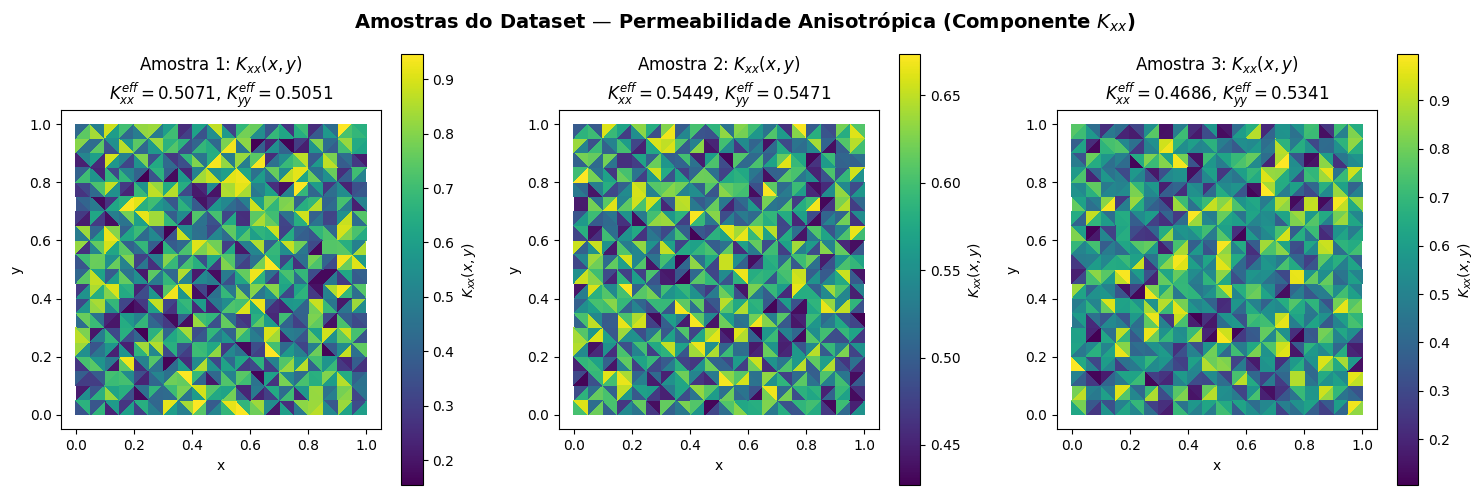


 Visualização das microestruturas concluída com sucesso.


In [48]:
# =============================================================================
# CARREGAMENTO DO DATASET DE HOMOGENEIZAÇÃO
# =============================================================================
# Os dados foram previamente gerados via simulações FEM (Firedrake)
# e armazenados em formato NumPy para garantir independência do solver
# e facilidade de pós-processamento.

# X_train: campos microscópicos de permeabilidade anisotrópica
#           Shape esperado: (N_amostras, 2, N_elementos)
#           onde:
#             • X_train[i][0] → K_xx(x,y)
#             • X_train[i][1] → K_yy(x,y)
X_train = np.load(os.path.join(PASTA_DADOS, "X_train.npy"))

# y_train: permeabilidades efetivas macroscópicas
#           Shape: (N_amostras, 2)
#           y_train[i] = [K_xx_eff, K_yy_eff]
y_train = np.load(os.path.join(PASTA_DADOS, "y_train.npy"))

# coords: coordenadas espaciais dos nós da malha FEM
#         Shape: (N_nós, 2)
#         Geometria fixa do domínio unitário
coords = np.load(os.path.join(PASTA_DADOS, "coords.npy"))


# =============================================================================
# CONSTRUÇÃO DA TRIANGULAÇÃO PARA VISUALIZAÇÃO
# =============================================================================
# A triangulação é utilizada apenas para visualização (matplotlib),
# não interferindo nos cálculos FEM ou no treinamento do modelo.
#
# Importante: assume-se que a ordenação dos valores de K(x,y)
# é consistente com a conectividade implícita da malha Firedrake.
triang = tri.Triangulation(coords[:, 0], coords[:, 1])


# =============================================================================
# VISUALIZAÇÃO DE AMOSTRAS REPRESENTATIVAS DO DATASET
# =============================================================================
# Para inspeção qualitativa, são plotadas as primeiras amostras
# do conjunto de dados, permitindo verificar:
#   • heterogeneidade espacial
#   • anisotropia direcional
#   • coerência entre microestrutura e K_eff

num_amostras_plot = min(3, len(X_train))

fig, axs = plt.subplots(1, num_amostras_plot, figsize=(15, 5))

# Garantia de consistência quando há apenas uma amostra
if num_amostras_plot == 1:
    axs = [axs]

for i in range(num_amostras_plot):
    
    # -------------------------------------------------------------------------
    # Extração da microestrutura da amostra i
    # -------------------------------------------------------------------------
    # K_xx_sample: campo local de permeabilidade na direção x
    # K_yy_sample: campo local de permeabilidade na direção y
    K_xx_sample = X_train[i][0]
    K_yy_sample = X_train[i][1]
    
    # Permeabilidades efetivas associadas (resultado da homogeneização)
    K_xx_eff, K_yy_eff = y_train[i]
    
    # -------------------------------------------------------------------------
    # Plot da componente K_xx(x,y)
    # -------------------------------------------------------------------------
    # A visualização destaca a estrutura espacial da permeabilidade
    # responsável pelo escoamento médio horizontal.
    tcf = axs[i].tripcolor(
        triang,
        K_xx_sample,
        cmap='viridis',
        shading='flat'
    )
    
    axs[i].set_aspect('equal')
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("y")
    
    axs[i].set_title(
        f"Amostra {i+1}: $K_{{xx}}(x,y)$\n"
        f"$K_{{xx}}^{{eff}} = {K_xx_eff:.4f}$, "
        f"$K_{{yy}}^{{eff}} = {K_yy_eff:.4f}$"
    )
    
    plt.colorbar(tcf, ax=axs[i], label="$K_{xx}(x,y)$")


# =============================================================================
# AJUSTES FINAIS DE FIGURA
# =============================================================================
plt.suptitle(
    "Amostras do Dataset — Permeabilidade Anisotrópica (Componente $K_{xx}$)",
    fontsize=14,
    fontweight='bold'
)

plt.tight_layout()
plt.show()

print("\n Visualização das microestruturas concluída com sucesso.")


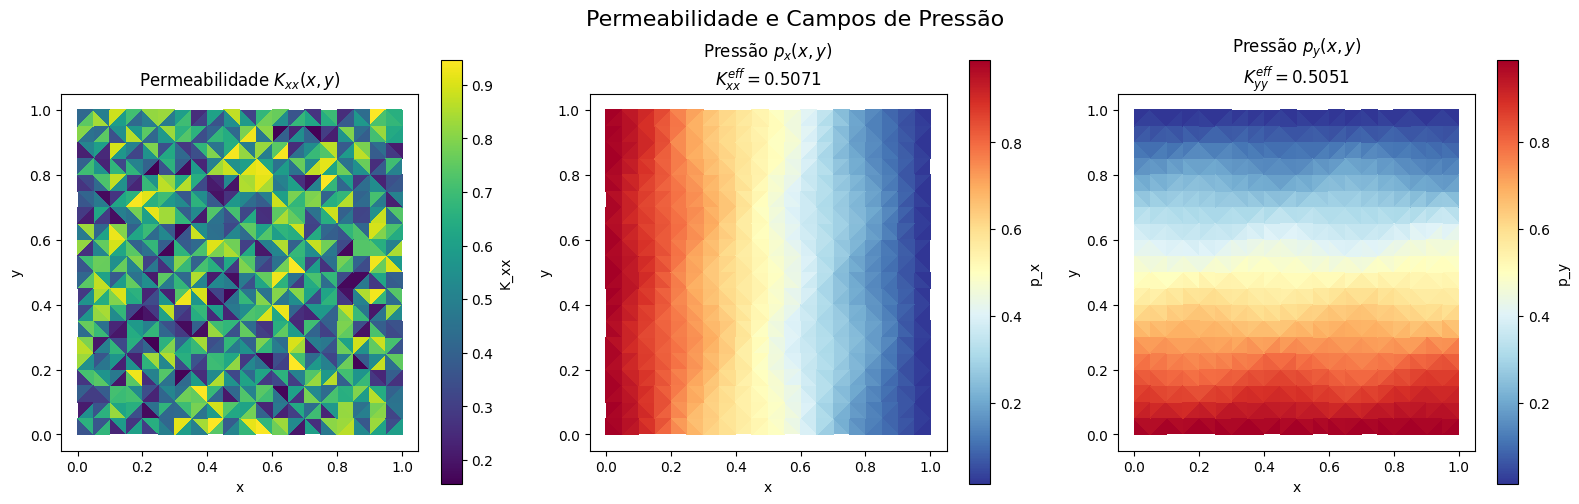

In [49]:
# ============================================================================
# COMPARAR PERMEABILIDADE E CAMPOS DE PRESSÃO (UMA AMOSTRA)
# ============================================================================

sample_id = 0  # escolher apenas uma amostra

# Criar figura: 1 amostra × 3 variáveis
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# Dados da amostra
K_xx_sample = X_train[sample_id][0]
p_x_sample = lista_pressao_x[sample_id]
p_y_sample = lista_pressao_y[sample_id]
K_xx_eff, K_yy_eff = y_train[sample_id]

# ----------------------------------------------------------------------
# Plot 1: Permeabilidade K_xx
# ----------------------------------------------------------------------
tcf1 = axs[0].tripcolor(triang, K_xx_sample,
                        cmap='viridis', shading='flat')
axs[0].set_aspect('equal')
axs[0].set_title("Permeabilidade $K_{xx}(x,y)$")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
plt.colorbar(tcf1, ax=axs[0], label="K_xx")

# ----------------------------------------------------------------------
# Plot 2: Pressão – Direção X
# ----------------------------------------------------------------------
tcf2 = axs[1].tripcolor(triang, p_x_sample,
                        cmap='RdYlBu_r', shading='flat')
axs[1].set_aspect('equal')
axs[1].set_title(f"Pressão $p_x(x,y)$\n$K_{{xx}}^{{eff}}={K_xx_eff:.4f}$")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.colorbar(tcf2, ax=axs[1], label="p_x")

# ----------------------------------------------------------------------
# Plot 3: Pressão – Direção Y
# ----------------------------------------------------------------------
tcf3 = axs[2].tripcolor(triang, p_y_sample,
                        cmap='RdYlBu_r', shading='flat')
axs[2].set_aspect('equal')
axs[2].set_title(f"Pressão $p_y(x,y)$\n$K_{{yy}}^{{eff}}={K_yy_eff:.4f}$")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
plt.colorbar(tcf3, ax=axs[2], label="p_y")

plt.suptitle("Permeabilidade e Campos de Pressão", fontsize=16)
plt.tight_layout()
plt.show()


